# IEEE-CIS Fraud Detection

__Overview:__ __Vesta Corporation__, seeking the best solutions for __fraud prevention__ industry, and now you are invited to join the challenge.

In this competition, you’ll benchmark machine learning models on a challenging large-scale dataset. The data comes from Vestas real-world e-commerce transactions and contains a wide range of features from device type to product features. You also have the opportunity to create new features to improve your results. 

__Data Description:__
In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.
The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.


https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-602696

__Transaction Table *__

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction 
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc. 
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked. 
- D1-D15: timedelta, such as days between previous transaction, etc. 
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain Remaildomain
- M1 - M9

__Identity Table *__

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. 
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
- DeviceType
- DeviceInfo
- id12 - id38

## Table of contents:
* [1.2 Data Analysis](#DataAnalysis)
    * [1.2.1 Train Data Exploration](#TrainDataExploration)
* [1.3 Preprocessing](#Preprocessing)
    * [1.3.1 New columns (Feature ingeniring)](#FeatureIngeniring)
* [1.4 Baseline Models](#BaselineModels)
* [1.5 Model Tuning](#ModelTuning)
    * [1.5.1 Regression analisys](#RegressionAnalisys)
    * [1.5.2 XGBoost analisys](#XGBoostAnalisys)
    * [1.5.3 Clasterization](#Clasterization)
    * [1.5.4 Model Parameters](#ModelParameters)
* [1.6 Feature selection](#FeatureSelection)
    * [1.6.1 Most Correlated](#MostCorrelated)
    * [1.6.2 Most Important](#MostImportant)
    * [1.6.2 ks_2samp](#ks_2samp)
* [1.7 Kagle Results](#Kaggle)    

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import math
import timeit
import datetime
import time
import os
import sys
import gc
import random

# Visualiazation
from seaborn import countplot
import matplotlib.pyplot as plt
# import seaborn

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.preprocessing import Imputer, LabelBinarizer
from sklearn.preprocessing import LabelEncoder, Imputer
from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline
from scipy.stats import ks_2samp

# Models and multiclasses support
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.linear_model import SGDRegressor
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans

# Metrics
from sklearn.metrics import roc_auc_score 

# Model tuning
# from sklearn.model_selection import GridSearchCV

# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def CReduction(df, col_old):
    col_new = col_old + '_new'
    min_ = df[col_old].min().astype(int)
    max_ = df[col_old].max().astype(int)
    for i in range(min_, max_):
        if df[col_old].value_counts(normalize=True)[:i].sum() > 0.99:
            n_cat = i + 10
            break

    df[col_new] = df[col_old]
    df.loc[df[col_new] > n_cat - 1, [col_new]] = n_cat
    # try:
    #    plot_fts(df, [col_old, col_new], n_cols=2)
    # except:
    #    n_cat = n_cat

    df[col_new].fillna(n_cat).astype(np.int8)

    # print(n_cat, df[col_old].value_counts(normalize=True)[:n_cat].sum())
    # df[col_old].value_counts(normalize=True)[:3]
    return df  # df.drop(col_old, axis=1, inplace=True)


def TrainAndPredict(X_train, y_train, imputer, scaler, scaler_name, outlier,
                    model, model_name, skf):
    ''' Function train the model and calculate roc_auc on cross validation '''

    # Create pipeline
    pipeline = Pipeline([('imputer', imputer), (scaler_name, scaler),
                         ('outlier', outlier), ('smote', smote),
                         (model_name, model)])

    # Calculate roc_auc on Cross Validation
    roc_auc = cross_val_score(
        pipeline, X_train, y_train, scoring='roc_auc', cv=skf).mean()

    return round(roc_auc, 4)


def SecondsToStr(time_taken):
    ''' Function return hours, minutes, seconds '''
    ''' from the time in string format. '''

    hours, rest = divmod(time_taken, 3600)
    minutes, seconds = divmod(rest, 60)
    h_ = str(math.trunc(hours))
    m_ = str(math.trunc(minutes))
    s_ = str(round(seconds, 2))
    time_taken_str = ':'.join([h_, m_, s_])

    # return hours, minutes, seconds from the time taken
    return time_taken_str


def reduce_mem_usage(df):
    ''' iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    '''
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(
                        np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(
                        np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(
                        np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(
                        np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(
                        np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(
                        np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def plot_fts(df, fts, n_cols=3, m_cat=10):
    n_fts = len(fts)
    n_rows = -(-n_fts // n_cols)  # ceiling division
    to_del = (n_cols - (n_fts % n_cols)) % n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3 * n_rows))
    plt.subplots_adjust(wspace=0.3, hspace=0.45)
    axes = (axes if type(axes) is np.ndarray else np.array(axes)).ravel()
    strp = lambda l: f"{float(l):g}" if l.replace(".", "").isdigit() else l[:7]
    np_col = df.select_dtypes(np.number).columns
    for i, ft in enumerate(fts):
        ax1 = axes[i]
        ax2 = ax1.twinx()
        if ft in np_col:
            cut, bins = pd.cut(df[ft], 10, retbins=True, right=False)
            ax1.hist(
                df[ft],
                bins,
                color="#A8DBA8",
                edgecolor="k",
                log=True,
                zorder=2)
            ax1.tick_params("x", pad=2)
            ax1.grid(zorder=0)
            ctrs = (bins[:-1] + bins[1:]) / 2
            vals = df.groupby(cut)["isFraud"].mean()
            ax2.plot(ctrs, vals, marker="o", c="#0B486B", lw=2)
        else:
            cts = df[ft].value_counts().nlargest(m_cat)
            ax1.bar(
                cts.index,
                cts.values,
                width=1,
                color="#a6cee3",
                edgecolor="k",
                log=True,
                zorder=2)
            ax1.tick_params("x", labelrotation=45, pad=0)
            ax1.grid(zorder=0)
            vals = df.groupby(ft)["isFraud"].mean().loc[cts.index]
            ax2.plot(vals, marker="o", c="#0B486B", lw=2)
            ax2.set_xticklabels(list(map(strp, cts.index)))
        ax1.minorticks_off()
        ax2.minorticks_off()
        ax1.set_ylim(1, 10**6)
        ax1.set_title(ft, loc="right")
    # ax2.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    for i in range(to_del, 0, -1):
        fig.delaxes(axes[-i])
    plt.show()


def plot_learning_curve(estimator,
                        title,
                        X,
                        y,
                        ylim=None,
                        cv=None,
                        n_jobs=1,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    ''' Generate a simple plot of the test and training learning curve. '''

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r")
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color='g')
    plt.plot(
        train_sizes,
        train_scores_mean,
        'o-',
        color='r',
        label='Training score')
    plt.plot(
        train_sizes,
        test_scores_mean,
        'o-',
        color='g',
        label='Cross-validation score')

    plt.legend(loc='best')
    return plt

In [4]:
# Model
import lightgbm as lgb


def make_predictions(tr_df, tt_df, features_columns, target, lgb_params, NFOLDS=2):

    folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=66)

    X, y = tr_df[features_columns], tr_df[target]
    # P,P_y = tt_df[features_columns], tt_df[target]
    P = tt_df[features_columns]

    tt_df = tt_df[['TransactionID']]
    predictions = np.zeros(len(tt_df))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        print('Fold:', fold_)
        tr_x, tr_y = X.iloc[trn_idx, :], y[trn_idx]
        vl_x, vl_y = X.iloc[val_idx, :], y[val_idx]

        print(len(tr_x), len(vl_x))
        tr_data = lgb.Dataset(tr_x, label=tr_y)

        vl_data = lgb.Dataset(vl_x, label=vl_y)

        estimator = lgb.train(
            lgb_params,
            tr_data,
            valid_sets=[tr_data, vl_data],
            verbose_eval=200)

        pp_p = estimator.predict(P)
        predictions += pp_p / NFOLDS

        del tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
        gc.collect()

    tt_df['prediction'] = predictions

    return tt_df, estimator

In [5]:
# seed everything for deterministic results
random.seed(66)
os.environ['PYTHONHASHSEED'] = str(66)
np.random.seed(66)

In [6]:
# import Datasets
start_time = time.time()

train_df = pd.read_csv('input_files/train_transaction.csv')
test_df = pd.read_csv('input_files/test_transaction.csv')
train_identity = pd.read_csv('input_files/train_identity.csv')
test_identity = pd.read_csv('input_files/test_identity.csv')

print('Total time: {}'.format(SecondsToStr(time.time() - start_time)))

Total time: 0:0:40.7


## Data Analysis <a class="anchor" id="DataAnalysis"></a>

### Train Data Exploration <a class="anchor" id="TrainDataExploration"></a>

very good data exploration and vizualization is here: 

https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
      
https://www.kaggle.com/jackdry/ieee-fraud-detection-exploratory-data-analysis

In [7]:
# some information about train dataset..
print('Data shape:', train_df.shape)
print('\n{}% train transactions have no corresponding identity information'.format(round(100 * (train_df.shape[0] - train_identity.shape[0])/train_df.shape[0], 2)))
print('\nTypes of the columns:', train_df.dtypes.value_counts())

# some information about test dataset..
print('Data shape:', test_df.shape)
print('\n{}% test transactions have no corresponding identity information'.format(round(100 * (test_df.shape[0] - test_identity.shape[0])/test_df.shape[0], 2)))
print('\nTypes of the columns:', test_df.dtypes.value_counts())

cat_cols = []
num_cols = []
for col in train_df.columns:
    if train_df[col].dtype == object:
        cat_cols.append(col)
    elif ((col != 'isFraud') and (col != 'TransactionID')):
        num_cols.append(col)
print('Numerical columns {}, categorical columns {}'.format(len(num_cols), len(cat_cols)))

Data shape: (590540, 394)

75.58% train transactions have no corresponding identity information

Types of the columns: float64    376
object      14
int64        4
dtype: int64
Data shape: (506691, 393)

71.99% test transactions have no corresponding identity information

Types of the columns: float64    376
object      14
int64        3
dtype: int64
Numerical columns 378, categorical columns 14


(590540, 394)
Share of the classes:
0    96.5
1     3.5
Name: isFraud, dtype: float64


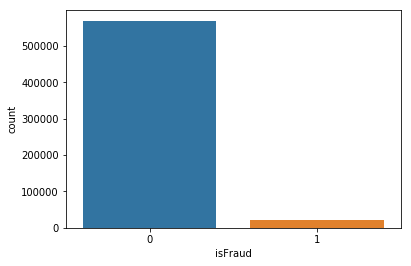

In [8]:
print(train_df.shape)

# Check the share of the classes
print('Share of the classes:')
print(round(train_df['isFraud'].value_counts(normalize=True)*100, 2))
countplot(x='isFraud', data=train_df)

In [9]:
# Crossvalidation StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# Outlier
outlier = RobustScaler()
# Average instead of the missing values
imputer = Imputer(missing_values=np.NAN, axis=1)
# Oversampling for the class balansing
smote = SMOTE(random_state=1)
# Scaler
scaler = Normalizer()

In [10]:
'''# оценим как много объектов действительно нужно для построения качественной модели. 
# Для обучения доступна достаточно большая выборка и может так оказаться, 
# что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. 
# Построим кривые обучения, обучая модель на выборках разного размера 
# начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. 

start_time = time.time()

# Create pipeline
pipeline = Pipeline([
        ('imputer', imputer),
        ('scaler', scaler),
        ('outlier', outlier),
        ('smote', smote),
        ('XGBoost', XGBClassifier(random_state=1))
    ])
plot_learning_curve(pipeline, 'Learning Curves (XGBClassifier)', X_train, y_train, cv=skf)
print('Total time: {}'.format(SecondsToStr(time.time() - start_time)))

plt.show()'''
print('')

## Preprocessing <a class="anchor" id="Preprocessing"></a>

### New columns (Feature' ingeniring) <a class="anchor" id="FeatureIngeniring"></a>

In [11]:
# C1-C14 analisys + New Features
# C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. 
# The actual meaning is masked. 
old_C_list = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
new_C_list = ['C1_new','C2_new','C3_new','C4_new','C5_new','C6_new','C7_new','C8_new','C9_new','C10_new','C11_new','C12_new','C13_new','C14_new']
for col in old_C_list :
    # print(col)
    train_df = CReduction(train_df, col)
    test_df = CReduction(test_df, col)
    

# add sum of the all columns
for df in [train_df , test_df]:
    df['C_Sum']  = df[new_C_list].sum(axis=1).astype(np.int8)
    df['C_NA'] = df[new_C_list].isna().sum(axis=1).astype(np.int8)

In [12]:
# M1-M9 New Features
# M1-M9: match, such as names on card and address, etc.
i_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']

for df in [train_df, test_df]:
    df['M_sum'] = df[i_cols].sum(axis=1).astype(np.int8)
    df['M_na'] = df[i_cols].isna().sum(axis=1).astype(np.int8)

In [13]:
# TransactionDT New Features
# TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
# Let's add temporary "time variables" for aggregations
# and add normal "time variables"

reference_datetime = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
reference_year = 2017

for df in [train_df, test_df]:
    # Temporary
    df['DT'] = df['TransactionDT'].apply(lambda x: (reference_datetime + datetime.timedelta(seconds=x)))
    
    df['DT_M'] = (df['DT'].dt.year - reference_year) * 12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year - reference_year) * 52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year - reference_year) * 365 + df['DT'].dt.dayofyear

    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day

    # Drop technical column
    df.drop('DT', axis=1, inplace=True)

In [14]:
# D9 column
# D1-D15: timedelta, such as days between previous transaction, etc. 
for df in [train_df, test_df]:
    df['D9'] = np.where(df['D9'].isna(), 0, 1)

In [15]:
# card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
# Reset values for "noisy" card1
for col in ['card1']:
    valid_card = pd.concat([train_df[[col]], test_df[[col]]])
    valid_card = valid_card[col].value_counts()
    valid_card = valid_card[valid_card > 2]
    valid_card = list(valid_card.index)

    train_df[col] = np.where(train_df[col].isin(test_df[col]), train_df[col], np.nan)
    test_df[col] = np.where(test_df[col].isin(train_df[col]), test_df[col], np.nan)

    train_df[col] = np.where(train_df[col].isin(valid_card), train_df[col], np.nan)
    test_df[col] = np.where(test_df[col].isin(valid_card), test_df[col], np.nan)

In [16]:
# ProductCD and M4 Target mean
for col in ['ProductCD', 'M4']:
    temp_dict = train_df.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    train_df[col + '_target_mean'] = train_df[col].map(temp_dict)
    test_df[col + '_target_mean'] = test_df[col].map(temp_dict)

In [17]:
# TransactionAmt

# Let's add some kind of client uID based on cardID ad addr columns
# The value will be very specific for each client so we need to remove it
# from final feature. But we can use it for aggregations.
train_df['uid'] = train_df['card1'].astype(str) + '_' + train_df['card2'].astype(str)
test_df['uid'] = test_df['card1'].astype(str) + '_' + test_df['card2'].astype(
    str)

train_df['uid2'] = train_df['uid'].astype(str) + '_' + train_df[
    'card3'].astype(str) + '_' + train_df['card5'].astype(str)
test_df['uid2'] = test_df['uid'].astype(str) + '_' + test_df['card3'].astype(
    str) + '_' + test_df['card5'].astype(str)

train_df['uid3'] = train_df['uid2'].astype(str) + '_' + train_df[
    'addr1'].astype(str) + '_' + train_df['addr2'].astype(str)
test_df['uid3'] = test_df['uid2'].astype(str) + '_' + test_df['addr1'].astype(
    str) + '_' + test_df['addr2'].astype(str)

# Check if the Transaction Amount is common or not (we can use freq encoding here)
# In our dialog with a model we are telling to trust or not to these values
train_df['TransactionAmt_check'] = np.where(
    train_df['TransactionAmt'].isin(test_df['TransactionAmt']), 1, 0)
test_df['TransactionAmt_check'] = np.where(
    test_df['TransactionAmt'].isin(train_df['TransactionAmt']), 1, 0)

# For our model current TransactionAmt is a noise
# https://www.kaggle.com/kyakovlev/ieee-check-noise
# (even if features importances are telling contrariwise)
# There are many unique values and model doesn't generalize well
# Lets do some aggregations
i_cols = ['card1', 'card2', 'card3', 'card5', 'uid', 'uid2', 'uid3']

for col in i_cols:
    for agg_type in ['mean', 'std']:
        new_col_name = col + '_TransactionAmt_' + agg_type
        temp_df = pd.concat([
            train_df[[col, 'TransactionAmt']], test_df[[col, 'TransactionAmt']]
        ])
        #temp_df['TransactionAmt'] = temp_df['TransactionAmt'].astype(int)
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg(
            [agg_type]).reset_index().rename(columns={agg_type: new_col_name})

        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()

        train_df[new_col_name] = train_df[col].map(temp_df)
        test_df[new_col_name] = test_df[col].map(temp_df)

# Small "hack" to transform distribution
# (doesn't affect auc much, but I like it more)
# please see how distribution transformation can boost your score
# (not our case but related)
# https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html
train_df['TransactionAmt'] = np.log1p(train_df['TransactionAmt'])
test_df['TransactionAmt'] = np.log1p(test_df['TransactionAmt'])

In [18]:
# 'P_emaildomain' - 'R_emaildomain'
p = 'P_emaildomain'
r = 'R_emaildomain'
uknown = 'email_not_provided'

for df in [train_df, test_df]:
    df[p] = df[p].fillna(uknown)
    df[r] = df[r].fillna(uknown)

    # Check if P_emaildomain matches R_emaildomain
    df['email_check'] = np.where((df[p] == df[r]) & (df[p] != uknown), 1, 0)

    df[p + '_prefix'] = df[p].apply(lambda x: x.split('.')[0])
    df[r + '_prefix'] = df[r].apply(lambda x: x.split('.')[0])

## Local test doesn't show any boost here,
## but I think it's a good option for model stability

## Also, we will do frequency encoding later

In [19]:
# Device info

for df in [train_identity, test_identity]:
    # Device info
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['DeviceInfo_version'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    # Device info 2
    df['id_30'] = df['id_30'].fillna('unknown_device').str.lower()
    df['id_30_device'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['id_30_version'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    # Browser
    df['id_31'] = df['id_31'].fillna('unknown_device').str.lower()
    df['id_31_device'] = df['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))

In [20]:
# Merge Identity columns
temp_df = train_df[['TransactionID']]
temp_df = temp_df.merge(train_identity, on=['TransactionID'], how='left')
del temp_df['TransactionID']
train_df = pd.concat([train_df,temp_df], axis=1)
    
temp_df = test_df[['TransactionID']]
temp_df = temp_df.merge(test_identity, on=['TransactionID'], how='left')
del temp_df['TransactionID']
test_df = pd.concat([test_df,temp_df], axis=1)

In [21]:
# Freq encoding
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo','DeviceInfo_device','DeviceInfo_version',
          'id_30','id_30_device','id_30_version',
          'id_31_device',
          'id_33',
          'uid','uid2','uid3',
         ]

for col in i_cols:
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    train_df[col+'_fq_enc'] = train_df[col].map(fq_encode)
    test_df[col+'_fq_enc']  = test_df[col].map(fq_encode)


for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    train_df[col+'_total'] = train_df[col].map(fq_encode)
    test_df[col+'_total']  = test_df[col].map(fq_encode)
        

periods = ['DT_M','DT_W','DT_D']
i_cols = ['uid']
for period in periods:
    for col in i_cols:
        new_column = col + '_' + period
            
        temp_df = pd.concat([train_df[[col,period]], test_df[[col,period]]])
        temp_df[new_column] = temp_df[col].astype(str) + '_' + (temp_df[period]).astype(str)
        fq_encode = temp_df[new_column].value_counts().to_dict()
            
        train_df[new_column] = (train_df[col].astype(str) + '_' + train_df[period].astype(str)).map(fq_encode)
        test_df[new_column]  = (test_df[col].astype(str) + '_' + test_df[period].astype(str)).map(fq_encode)
        
        train_df[new_column] /= train_df[period+'_total']
        test_df[new_column]  /= test_df[period+'_total']

In [22]:
# Categorical Treatment
start_time = time.time()
# заменить все редкие хэши на слово Rare (редкие = встречаются реже 0.5%),
# заменить все пропущенные данные на слово Missing и развернуть как бинарную переменную

for col in list(train_df):
    if train_df[col].dtype == 'O':
        # print(col)

        train_df[col] = train_df[col].astype(str)
        test_df[col] = test_df[col].astype(str)

        train_df[col].fillna('Missing', inplace=True)
        test_df[col].fillna('Missing', inplace=True)

        thr = 0.005
        df = train_df[col].append(test_df[col])
        df[col] = train_df[col].append(test_df[col])
        d = dict(df[col].value_counts(dropna=False) / len(df[col]))

        train_df[col] = train_df[col].apply(
            lambda x: 'Rare' if d[x] <= thr else x)
        test_df[col] = test_df[col].apply(
            lambda x: 'Rare' if d[x] <= thr else x)

        # train_df[col] = train_df[col].fillna('unseen_before_label')
        # test_df[col]  = test_df[col].fillna('unseen_before_label')

        # train_df[col] = train_df[col].astype(str)
        # test_df[col] = test_df[col].astype(str)

        le = LabelEncoder()
        le.fit(list(train_df[col]) + list(test_df[col]))
        train_df[col] = le.transform(train_df[col])
        test_df[col] = le.transform(test_df[col])

        train_df[col] = train_df[col].astype('category')
        test_df[col] = test_df[col].astype('category')

print('Total time: {}'.format(SecondsToStr(time.time() - start_time)))

Total time: 0:1:55.14


In [ ]:
# Reduce mem_usage

num_cols = []
for col in test_df.columns:
    if (test_df[col].dtype == float) or (test_df[col].dtype == int):
        num_cols.append(col)

start_time = time.time()
train_df[num_cols] = reduce_mem_usage(train_df[num_cols])

test_df[num_cols] = reduce_mem_usage(test_df[num_cols])
print('Total time: {}'.format(SecondsToStr(time.time() - start_time)))

Memory usage of dataframe is 2203.17 MB
Memory usage after optimization is: 645.41 MB
Decreased by 70.7%
Memory usage of dataframe is 1890.35 MB


In [ ]:
y_train = train_df['isFraud']
X_train = train_df.drop('isFraud', axis=1)

X_test = test_df

print(train_df.shape)
print(test_df.shape)

## Baseline Models <a class="anchor" id="BaselineModels"></a>

In [ ]:
start_time = time.time()

# Try different types of Classifiers
baseline_models = [
     ('LogRegression   ', LogisticRegression(random_state=1)),
     ('Ridge           ', RidgeClassifier(random_state=1)),
     ('RandomForest    ', RandomForestClassifier(random_state=1)),
     ('GradientBoosting', GradientBoostingClassifier(random_state=1)),
     ('XGBoost         ', XGBClassifier(random_state=1)),
]

best_roc_auc = 0
for model_name, model in baseline_models:
    roc_auc = TrainAndPredict(X_train[:15000], y_train[:15000], imputer, scaler, 'scaler', outlier, model, model_name, skf)
    print(model_name, roc_auc)
    if roc_auc > best_roc_auc:
        best_model = model
        best_model_name = model_name
        best_roc_auc = roc_auc
        
print('\nBest model is {} best score is {}'.format(best_model_name, best_roc_auc))

print('Total time: {}'.format(SecondsToStr(time.time() - start_time)))

In [ ]:
# Comparison with lightgbm

# Model params
lgb_params = {
                    'objective': 'binary',
                    'boosting_type': 'gbdt',
                    'metric': 'auc',
                    'n_jobs': -1,
                    'learning_rate': 0.01,
                    'num_leaves': 2**8,
                    'max_depth': -1,
                    'tree_learner': 'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq': 1,
                    'subsample': 0.7,
                    'n_estimators': 800,
                    'max_bin': 255,
                    'verbose': -1,
                    'seed': 66,
                }

start_time = time.time()

gbm = lgb.train(lgb_params, lgb.Dataset(X_train[:15000], y_train[:15000]))

y_pred = gbm.predict(X_train[15001:], num_iteration=gbm.best_iteration)

print('The roc_auc_score of prediction is:', round(roc_auc_score(y_train[15001:], y_pred), 4))

print('Total time: {}'.format(SecondsToStr(time.time() - start_time)))

In [ ]:
# feature importances
# print('Feature importances:', list(gbm.feature_importance()))

## Model Tuning <a class="anchor" id="ModelTuning"></a>

### Regression analisys <a class="anchor" id="RegressionAnalisys"></a>

https://habr.com/ru/post/270367/

Регрессия в качестве регрессора


Следующий шаг уже не такой банальный. Из распределения классов я предположил, что возрастные группы упорядочены, то есть 0<1…<6 или наоборот. А раз так, то можно не классифицировать, а строить регрессию. Она будет работать плохо, но зато её результат можно передать другим алгоритмам для обучения. Поэтому запускаем обычную линейную регрессию с функцией потерь huber и оптимизируем её через стохастический градиентный спуск.

In [ ]:
start_time = time.time()

sgd_pipeline = Pipeline([
        ('imputer', imputer),
        ('Normalizer', Normalizer()),
        ('outlier', outlier),
        ('smote', smote),
        ('sgd', SGDRegressor(loss='huber', n_iter_no_change=100))
    ])
sgd_pipeline.fit(X_train, y_train)

# New features from regression' analisys
X_train = pd.concat([X_train, pd.DataFrame(sgd_pipeline.predict(X_train)[None].T, columns=['sgd_prediction'])], axis=1)
X_test = pd.concat([X_test, pd.DataFrame(sgd_pipeline.predict(X_test)[None].T, columns=['sgd_prediction'])], axis=1)

print('Total time: {}'.format(SecondsToStr(time.time() - start_time)))

### XGBoost analisys <a class="anchor" id="XGBoostAnalisys"></a>

In [ ]:
''' start_time = time.time()

XGB_pipeline = Pipeline([
    ('imputer', imputer), 
    ('Normalizer', Normalizer()),
    ('outlier', outlier), 
    ('smote', smote),
    ('XGB', XGBClassifier(silent=False, nthread=4, max_depth=10, n_estimators=800, subsample=0.5, learning_rate=0.03, seed=66, random_state=1))])

XGB_pipeline.fit(X_train, y_train)

# New features from regression' analisys
X_train = pd.concat([X_train, pd.DataFrame(XGB_pipeline.predict(X_train)[None].T, columns=['XGB_prediction'])], axis=1)
X_test = pd.concat([X_test, pd.DataFrame(XGB_pipeline.predict(X_test)[None].T, columns=['XGB_prediction'])], axis=1)

print('Total time: {}'.format(SecondsToStr(time.time() - start_time))) '''
print('')

### Clasterization <a class="anchor" id="Clasterization"></a>

https://habr.com/ru/post/270367/

Вторая интересная мысль, которую я пробовал: кластеризация данных методом k-средних. Если в данных есть реальная структура (а в данных по абонентам она должна быть), то k-средних её почувствует. Сначала я взял k=7, потом добавил 3 и 15 (в два раза больше и в два раза меньше). Предсказания каждого из этих алгоритмов — номера кластеров для каждого образца. Так как эти номера не упорядочены, то оставить их числами нельзя, надо обязательно бинаризовать.

In [ ]:
# Clasters

start_time = time.time()

best_scaler = Normalizer()
best_scaler_name = 'Normalizer'

k_models = [
     ('k10', KMeans(n_clusters=10, precompute_distances=True, n_jobs=-1)),
     ('k7', KMeans(n_clusters=7, precompute_distances=True, n_jobs=-1)),
     ('k6', KMeans(n_clusters=6, precompute_distances=True, n_jobs=-1)),
     ('k5', KMeans(n_clusters=5, precompute_distances=True, n_jobs=-1)),
     ('k4', KMeans(n_clusters=4, precompute_distances=True, n_jobs=-1)),
     ('k3', KMeans(n_clusters=3, precompute_distances=True, n_jobs=-1)),
     ('k2', KMeans(n_clusters=2, precompute_distances=True, n_jobs=-1))
]

for k_name, k_model in k_models:
    print(k_name)
    k_pipeline = Pipeline([
        ('imputer', imputer),
        ('Normalizer', Normalizer()),
        (k_name, k_model)
    ])
    k_pipeline.fit(X_train)
    # New features from clusterization
    X_train = pd.concat([X_train, pd.DataFrame(k_pipeline.predict(X_train)[None].T, columns=[k_name + '_prediction'])], axis=1)
    X_test = pd.concat([X_test, pd.DataFrame(k_pipeline.predict(X_test)[None].T, columns=[k_name + '_prediction'])], axis=1)

# binarization (+25 new features)
X_train = pd.get_dummies(X_train, columns=['k10_prediction', 'k7_prediction', 'k6_prediction', 'k5_prediction', 'k4_prediction', 'k3_prediction', 'k2_prediction'])
X_test = pd.get_dummies(X_test, columns=['k10_prediction', 'k5_prediction', 'k7_prediction', 'k6_prediction', 'k4_prediction', 'k3_prediction', 'k2_prediction'])

print('Total time: {}'.format(SecondsToStr(time.time() - start_time)))

### Model Parameters <a class="anchor" id="ModelParameters"></a>

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
    
__For Better Accuracy__

- Use large max_bin (may be slower)
- Use small learning_rate with large num_iterations
- Use large num_leaves (may cause over-fitting)
- Use bigger training data
- Try dart

__Deal with Over-fitting__

- Use small max_bin
- Use small num_leaves
- Use min_data_in_leaf and min_sum_hessian_in_leaf
- Use bagging by set bagging_fraction and bagging_freq
- Use feature sub-sampling by set feature_fraction
- Use bigger training data
- Try lambda_l1, lambda_l2 and min_gain_to_split for regularization
- Try max_depth to avoid growing deep tree

In [ ]:
start_time = time.time()

best_roc_auc = 0
#Try dart
for boosting_type in ['gbdt', 'dart']:
    #Use small learning_rate with large num_iterations
    for learning_rate in [0.005]:#[0.001, 0.005, 0.005, 0.05]:
        for n_estimators in [1800]:#[3000, 2000, 1000]:
            #Use large num_leaves (may cause over-fitting)
            for num_leaves in [2**10]:#, 2**8, 2**10]:
   
                params = {
                    'boosting_type': boosting_type,
                    'num_leaves': num_leaves,
                    'learning_rate': learning_rate,
                    'n_estimators':  n_estimators,
                }

                gbm = lgb.train(params, lgb.Dataset(X_train[:15000], y_train[:15000]))
                y_pred = gbm.predict(X_train[15001:], num_iteration=gbm.best_iteration)
                roc_auc = roc_auc_score(y_train[15001:], y_pred)
                print('boosting_type: {} num_leaves: {} learning_rate: {} n_estimators: {} roc_auc: {}'.format(boosting_type, num_leaves, learning_rate, n_estimators, roc_auc))

                if roc_auc > best_roc_auc:
                    best_boosting_type = boosting_type
                    best_num_leaves = num_leaves
                    best_learning_rate = learning_rate
                    best_n_estimators = n_estimators
                    best_roc_auc = roc_auc

print('Total time: {}'.format(SecondsToStr(time.time() - start_time)))

In [ ]:
'''start_time = time.time()

best_roc_auc = 0
#Try dart
for boosting_type in ['gbdt', 'dart']:
    #Use small learning_rate with large num_iterations
    for learning_rate in [0.001, 0.005, 0.005, 0.05]:
        for n_estimators in [3000, 2000, 1000]:
            #Use large num_leaves (may cause over-fitting)
            for num_leaves in [2**6, 2**8, 2**10]:
   
                params = {
                    'boosting_type': boosting_type,
                    'num_leaves': num_leaves,
                    'learning_rate': learning_rate,
                    'n_estimators':  n_estimators,
                }

                gbm = lgb.train(params, lgb.Dataset(X_train[:15000], y_train[:15000]))
                y_pred = gbm.predict(X_train[15001:], num_iteration=gbm.best_iteration)
                roc_auc = roc_auc_score(y_train[15001:], y_pred)
                print('boosting_type: {} num_leaves: {} learning_rate: {} n_estimators: {} roc_auc: {}'.format(boosting_type, num_leaves, learning_rate, n_estimators, roc_auc))

                if roc_auc > best_roc_auc:
                    best_boosting_type = boosting_type
                    best_num_leaves = num_leaves
                    best_learning_rate = learning_rate
                    best_n_estimators = n_estimators
                    best_roc_auc = roc_auc

print('Total time: {}'.format(SecondsToStr(time.time() - start_time)))'''
print('')

## Feature Selection <a class="anchor" id="FeatureSelection"></a>

### Most Correlated <a class="anchor" id="MostCorrelated"></a>

In [ ]:
'''# Correlation (for the numerical colimns)
pd.concat([y_train, X_train], axis=1)
corr = pd.concat([y_train, X_train], axis=1).corr()

# Correlation to target variable
corr_to_target = abs(corr['isFraud'].iloc[1:].copy())
corr_to_target.sort_values(ascending=False, inplace=True)

corr_to_target[corr_to_target > 0.30].plot(kind='bar', title='Correlation with target variable (Top correlated features)')

# Features with the highest correlation to target
correlated_features = corr_to_target[corr_to_target > 0.30].index.tolist()
len(correlated_features)

# correlated_features
# roc_auc = TrainAndPredict(X_train[correlated_features], y_train, imputer, best_scaler, 'scaler', outlier, best_model, best_model_name, skf)
# print('Most Correlated: ', roc_auc)'''

print('')

In [ ]:
# XGB_pipeline.steps[4][1]

### Most Important <a class="anchor" id="MostImportant"></a>

In [ ]:
'''importances = XGB_pipeline.steps[4][1].feature_importances_
feature_importances = pd.Series(importances, index=[list(X_train)[i] for i in range(len(importances))]).sort_values(ascending=False)

# Visualization
feature_importances[0:30].plot(kind='bar', title='Feature Importances')

# Score 88.25%'''

print('')

### ks_2samp <a class="anchor" id="ks_2samp"></a>

In [ ]:
# Model Features
# We can use set().difference() but the order matters
# Matters only for deterministic results
# In case of remove() we will not change order
# even if variable will be renamed
# please see this link to see how set is ordered
# https://stackoverflow.com/questions/12165200/order-of-unordered-python-sets

rm_cols = [
    'TransactionID', 'TransactionDT',   # These columns are pure noise right now
    'isFraud',                          # Not target in features))
    'uid', 'uid2', 'uid3',              # Our new client uID -> very noisy data
    'bank_type',                        # Victims bank could differ by time
    'DT', 'DT_M', 'DT_W', 'DT_D',       # Temporary Variables
  #  'DT_hour', 'DT_day_week', 'DT_day',
    'DT_D_total', 'DT_W_total', 'DT_M_total',
    'id_30', 'id_31', 'id_33',
]

'''features_check = []
columns_to_check = set(list(X_train)).difference(set(list(X_test)) + rm_cols)
print('columns_to_check:', columns_to_check)
for i in columns_to_check:
    features_check.append(ks_2samp(X_test[i], X_train[i])[1])

features_check = pd.Series(
    features_check, index=columns_to_check).sort_values()
features_discard = list(features_check[features_check == 0].index)
print('features_discard:',features_discard)'''

print('')

In [ ]:
# Model Features
# We can use set().difference() but the order matters
# Matters only for deterministic results
# In case of remove() we will not change order
# even if variable will be renamed
# please see this link to see how set is ordered
# https://stackoverflow.com/questions/12165200/order-of-unordered-python-sets

# Final features list
features_columns = [col for col in list(X_test) if col not in rm_cols]
features_columns

## Kaggle Results <a class="anchor" id="Kaggle"></a>

In [ ]:
train_df_regression_clasterization = pd.concat([y_train, X_train], axis=1)
test_df_regression_clasterization = X_test

print(train_df_regression_clasterization.shape)
print(test_df_regression_clasterization.shape)

In [ ]:
# Model params
lgb_params = {
                    'objective': 'binary',
                    'boosting_type': 'gbdt',
                    'metric': 'auc',
                    'n_jobs': -1,
                    'learning_rate': 0.005,
                    'num_leaves': 2**8,
                    'max_depth': -1,
                    'tree_learner': 'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq': 1,
                    'subsample': 0.7,
                    'n_estimators': 1800,
                    'max_bin': 255,
                    'verbose': -1,
                    'seed': 66,
                    'early_stopping_rounds': 100,
                }

In [ ]:
start_time = time.time()

test_predictions, model = make_predictions(train_df_regression_clasterization, test_df_regression_clasterization, features_columns, 'isFraud', lgb_params, NFOLDS=10)

print('Total time: {}'.format(SecondsToStr(time.time() - start_time)))

In [ ]:
test_predictions['isFraud'] = test_predictions['prediction']
test_predictions[['TransactionID','isFraud']].to_csv('test_{}.csv'.format('20.09.2019'), index=False)

In [ ]:
print('done')